In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import LibDataImport
import weather

In [2]:
# Load utilization summary data into a DataFrame, one column per computer.
machineStates = pd.read_csv(r'../data/SPR2017.csv')
machineStates['datestamp'] = machineStates['datestamp'].apply(pd.to_datetime)
utilization = LibDataImport.machineStatesToPercentUtilization(machineStates)

In [3]:
utilization.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3604 entries, 2017-01-01 20:00:00 to 2017-05-31 23:00:00
Freq: H
Columns: 275 entries, BL001 to TL902
dtypes: float64(275)
memory usage: 7.6 MB


In [4]:
# Make this notebook useful for something.
%matplotlib inline

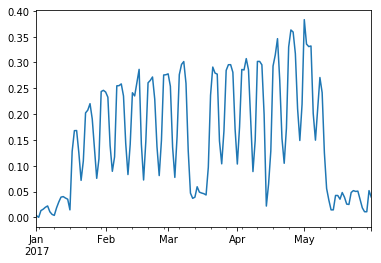

In [7]:
# Resample the utilization data to daily and monthly periods for cases where we don't care about intra-day trends.
daily = utilization.resample('D').mean()
monthly = utilization.resample('M').mean()
hourlyAggregate = utilization.apply(lambda x: x.mean(), axis=1)
dailyAggregate = daily.apply(lambda x: x.mean(), axis=1)
monthlyAggregate = monthly.apply(lambda x: x.mean(), axis=1)

# There seems to be a pretty clear weekly trend here, though...
dailyAggregate.plot()

In [8]:
# Pull in weather data.
gsoWeather = weather.parseWeatherData('../data/1052640.csv')
gsoWeather.index

DatetimeIndex(['2017-01-01 00:54:00', '2017-01-01 01:54:00',
               '2017-01-01 02:54:00', '2017-01-01 03:54:00',
               '2017-01-01 04:54:00', '2017-01-01 05:54:00',
               '2017-01-01 06:52:00', '2017-01-01 06:54:00',
               '2017-01-01 07:13:00', '2017-01-01 07:52:00',
               ...
               '2017-08-22 14:54:00', '2017-08-22 15:54:00',
               '2017-08-22 16:00:00', '2017-08-22 16:54:00',
               '2017-08-22 18:54:00', '2017-08-22 19:54:00',
               '2017-08-22 20:54:00', '2017-08-22 21:54:00',
               '2017-08-22 22:54:00', '2017-08-22 23:54:00'],
              dtype='datetime64[ns]', name=u'DATE', length=8910, freq=None)

In [9]:
# Our library data only contains records from 2017-01-01 thru 2017-05-31.
# Trim the weather data down to the same date range.
gsoWeather = gsoWeather[gsoWeather.index <= '2017-05-31']
gsoWeather.index

DatetimeIndex(['2017-01-01 00:54:00', '2017-01-01 01:54:00',
               '2017-01-01 02:54:00', '2017-01-01 03:54:00',
               '2017-01-01 04:54:00', '2017-01-01 05:54:00',
               '2017-01-01 06:52:00', '2017-01-01 06:54:00',
               '2017-01-01 07:13:00', '2017-01-01 07:52:00',
               ...
               '2017-05-30 17:54:00', '2017-05-30 18:54:00',
               '2017-05-30 19:00:00', '2017-05-30 19:54:00',
               '2017-05-30 20:54:00', '2017-05-30 21:54:00',
               '2017-05-30 22:00:00', '2017-05-30 22:54:00',
               '2017-05-30 23:54:00', '2017-05-30 23:59:00'],
              dtype='datetime64[ns]', name=u'DATE', length=5775, freq=None)

In [10]:
# Now, we really only need some of these columns.
gsoHourlyWeather = weather.hourlyWeatherOnly(gsoWeather)

# Initially, let's just focus on temperature, wind-speed, and precipitation.
columnsOfInterest = [ 'HOURLYWETBULBTEMPF'
                    , 'HOURLYDRYBULBTEMPF'
                    , 'HOURLYWindSpeed'
                    , 'HOURLYWindGustSpeed'
                    , 'HOURLYPrecip' ]
gsoWeatherCore = gsoHourlyWeather[columnsOfInterest]

# Clean up incorrect values.
gsoWeatherCore = gsoWeatherCore.replace(to_replace='[^0-9.-]', value='', regex=True)
gsoWeatherCore = gsoWeatherCore.replace(to_replace='', value='0').apply(np.float64)

In [11]:
# Now if we resample this to daily or monthly aggregate values, some columns
# need to have their values averaged, and others need to be summed.

def aggregateMatrix(df, period=None):
    needAverage = df[columnsOfInterest[:-1]]
    needSum = df['HOURLYPrecip']
    if period!=None:
        needAverage = needAverage.resample(period)
        needSum = needSum.resample(period)
    periodAverage = needAverage.mean()
    periodSum = needSum.sum()
    return periodAverage.join(periodSum, how='inner')

# Now re-join these...
dailyWeather = aggregateMatrix(gsoWeatherCore, 'D')
monthlyWeather = aggregateMatrix(gsoWeatherCore, 'M')

# And finally join with library data.  This gives us individual computer usage, as well as a subset of
# the weather data, in hourly, daily, and monthly periods.
matrixHourly = pd.DataFrame(hourlyAggregate, columns=['Utilization(%)']).join(gsoWeatherCore, how='inner')
matrixDaily = pd.DataFrame(dailyAggregate, columns=['Utilization(%)']).join(dailyWeather, how='inner')
matrixMonthly = pd.DataFrame(monthlyAggregate, columns=['Utilization(%)']).join(monthlyWeather, how='inner')

In [12]:
# It might be interesting to look at this data by each day of the week, too.
daysOfWeek = [ 'Monday'
             , 'Tuesday'
             , 'Wednesday'
             , 'Thursday'
             , 'Friday'
             , 'Saturday'
             , 'Sunday' ]

matrixDaily['Day of week'] = [daysOfWeek[d] for d in matrixDaily.index.dayofweek]

In [13]:
# Summary by day of week...
matrixDaily.groupby(by='Day of week').mean()

,Utilization(%),HOURLYWETBULBTEMPF,HOURLYDRYBULBTEMPF,HOURLYWindSpeed,HOURLYWindGustSpeed,HOURLYPrecip
Day of week,,,,,,
Friday,0.113797,49.666719,54.264487,8.892514,24.207236,0.338571
Monday,0.195401,49.941508,54.203261,8.191547,22.300952,0.509545
Saturday,0.071933,49.865643,54.834119,8.710073,22.668864,0.319524
Sunday,0.108415,48.641120,53.121514,8.461025,22.609495,0.139545
Thursday,0.193939,50.376930,55.215634,9.268730,25.157781,0.044286
Tuesday,0.207906,52.745999,57.390258,8.835040,23.438405,0.374545
Wednesday,0.215215,52.991384,57.330780,8.150301,24.460615,0.194762


In [14]:
# There is a weak positive correlation between the temperature and aggregate computer usage.
matrixHourly[['Utilization(%)','HOURLYDRYBULBTEMPF']].corr()

,Utilization(%),HOURLYDRYBULBTEMPF
Utilization(%),1.000000,0.338452
HOURLYDRYBULBTEMPF,0.338452,1.000000


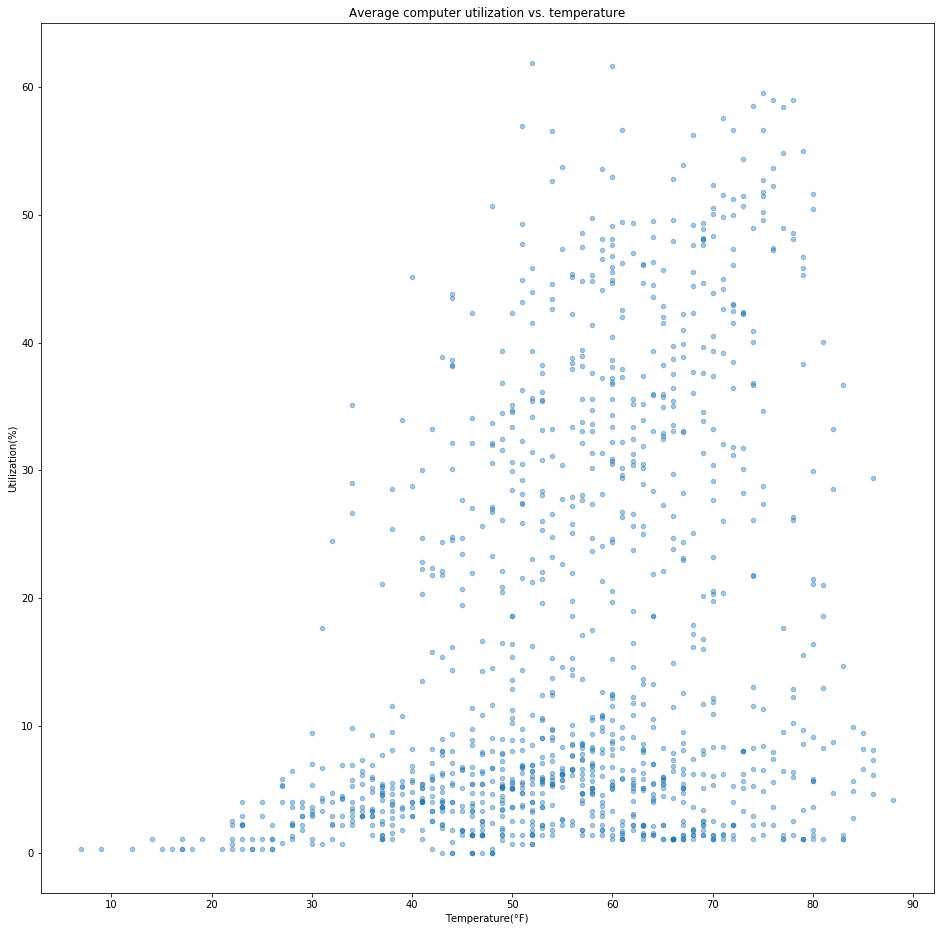

In [15]:
# It seems that there is a pretty clear upper bound on usage that scales linearly-ish with outside temperature.
x_y = matrixHourly[['Utilization(%)', 'HOURLYDRYBULBTEMPF']].rename(columns={'HOURLYDRYBULBTEMPF':'Temperature(°F)'})
x_y['Utilization(%)'] = x_y['Utilization(%)'].apply(lambda x: x * 100.0)
x_y.plot.scatter(x='Temperature(°F)', y='Utilization(%)', alpha=0.4, figsize=(16,16), title='Average computer utilization vs. temperature')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1193 entries, 2017-01-01 22:00:00 to 2017-05-30 22:00:00
Columns: 276 entries, HOURLYDRYBULBTEMPF to TL902
dtypes: float64(276)
memory usage: 2.5 MB


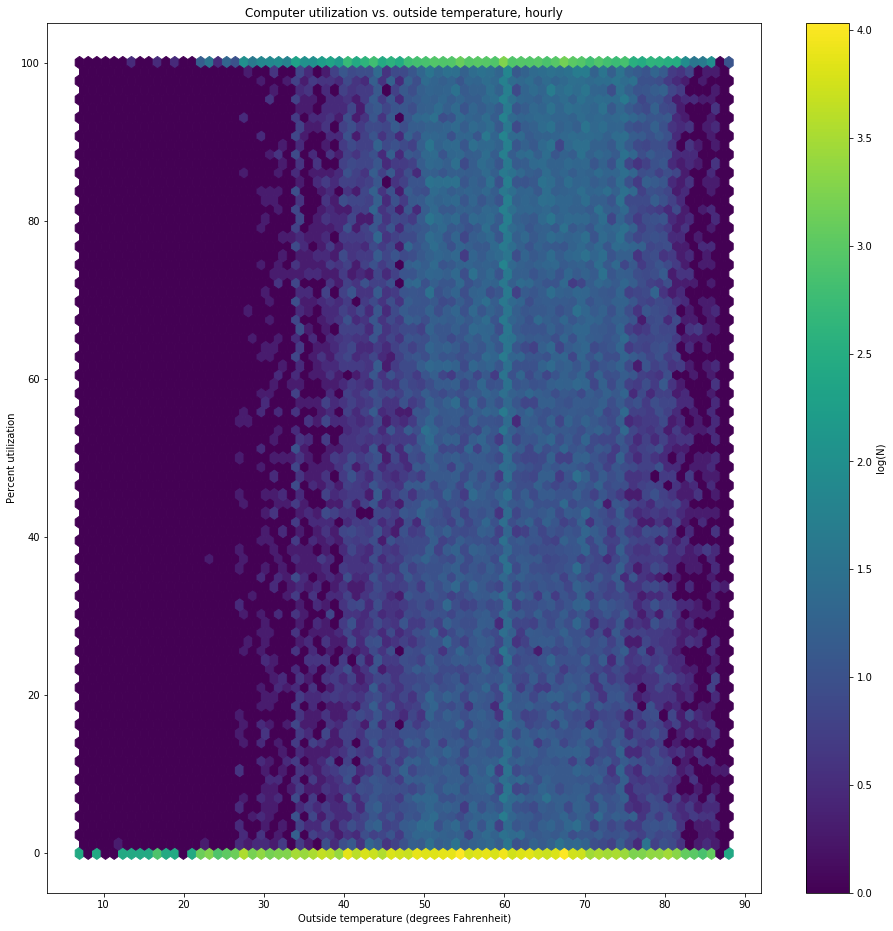

In [16]:
# However it seems that temperature has little impact on the amount of use any given computer receives.

merged = gsoWeatherCore[['HOURLYDRYBULBTEMPF']].join(utilization, how='inner')
merged.info()

# Remove RRK001 because it seems to always be on, which is unlikely to be due to student use.
computerUsage = merged.drop(['HOURLYDRYBULBTEMPF', 'RRK001'], axis=1)
temps = merged['HOURLYDRYBULBTEMPF']

fig = plt.figure(figsize=(16,16))
temps = np.hstack([temps] * len(computerUsage.columns))
usage = np.hstack([(x * 100.0).values for (_,x) in computerUsage.iteritems()])
hb = plt.hexbin(temps, usage, bins='log', gridsize=75)
hb.axes.set_title('Computer utilization vs. outside temperature, hourly')
hb.axes.set_xlabel('Outside temperature (degrees Fahrenheit)')
hb.axes.set_ylabel('Percent utilization')
cb = fig.colorbar(hb)
cb.set_label('log(N)')